In [2]:
# !pip install -U segmentation-models-pytorch albumentations --user
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
# import cv2
# import matplotlib.pyplot as plt
import linzhutils as lu
from testdataset import Dataset
from torch.utils.data import DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
DATA_DIR = '/scratch/project_2007251/2019/hel2019/'

IMAGE_DIR = 'output'
MASK_DIR = 'output'

img_dir = os.path.join(DATA_DIR, IMAGE_DIR)
anno_dir = os.path.join(DATA_DIR, MASK_DIR)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(512, 512)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [4]:
# load best saved checkpoint
model = torch.load('./models/kussi_FPN_efficientnet-b7_7_0.490.pth')
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['kussi']
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [5]:
# create test dataset

test_dataset = Dataset(
    img_dir,
    anno_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
def save_masks(masks):
    global file_num
    filename = f"/scratch/project_2007251/2019/results/result_masks_{file_num}.npy"
    concatenated = np.concatenate(masks, axis=0)
    reshaped = concatenated.reshape((-1, 512, 512))
    np.save(filename, np.array(masks))
    print(f"Saved {filename}")
    file_num += 1

In [8]:
fileList = []
for i in test_dataset.ids:
    fileList.append(os.path.join(img_dir, i))
np.save('/scratch/project_2007251/2019/results/file_list.npy',np.array(fileList))

In [9]:
batch_size = 128
input_batch = []
mask_batch = []
result_masks = []
file_num = 0
total_size = 0

for i in tqdm(range(len(test_dataset))):
    n = np.random.choice(len(test_dataset))
    image, gt_mask = test_dataset[n]
    input_batch.append(image)
    gt_mask = gt_mask.squeeze()
    mask_batch.append(gt_mask)

    if len(input_batch) == batch_size:
        x_tensor = torch.from_numpy(np.array(input_batch)).to(DEVICE)
        # print(x_tensor.shape)
        pr_mask_batch = model.predict(x_tensor).squeeze().cpu().numpy().round()
        result_masks.append(pr_mask_batch)
        total_size += pr_mask_batch.nbytes

        if total_size > 1e9:
            save_masks(result_masks)
            result_masks = []
            total_size = 0

        input_batch = []
        mask_batch = []
save_masks(result_masks)

  2%|▏         | 1026/50400 [01:29<6:34:34,  2.09it/s]

Saved /scratch/project_2007251/2019/results/result_masks_0.npy


  4%|▍         | 2052/50400 [02:55<5:46:31,  2.33it/s]

Saved /scratch/project_2007251/2019/results/result_masks_1.npy


  6%|▌         | 3073/50400 [04:22<9:31:53,  1.38it/s]

Saved /scratch/project_2007251/2019/results/result_masks_2.npy


  8%|▊         | 4097/50400 [05:42<7:00:50,  1.83it/s]

Saved /scratch/project_2007251/2019/results/result_masks_3.npy


 10%|█         | 5123/50400 [07:03<6:19:41,  1.99it/s]

Saved /scratch/project_2007251/2019/results/result_masks_4.npy


 12%|█▏        | 6146/50400 [08:23<5:18:07,  2.32it/s]

Saved /scratch/project_2007251/2019/results/result_masks_5.npy


 14%|█▍        | 7170/50400 [09:43<6:00:38,  2.00it/s]

Saved /scratch/project_2007251/2019/results/result_masks_6.npy


 16%|█▋        | 8195/50400 [11:01<4:39:43,  2.51it/s]

Saved /scratch/project_2007251/2019/results/result_masks_7.npy


 18%|█▊        | 9219/50400 [12:21<5:24:05,  2.12it/s]

Saved /scratch/project_2007251/2019/results/result_masks_8.npy


 20%|██        | 10240/50400 [13:35<4:56:49,  2.26it/s]

Saved /scratch/project_2007251/2019/results/result_masks_9.npy


 22%|██▏       | 11268/50400 [14:49<3:45:04,  2.90it/s]

Saved /scratch/project_2007251/2019/results/result_masks_10.npy


 24%|██▍       | 12288/50400 [16:02<5:09:27,  2.05it/s]

Saved /scratch/project_2007251/2019/results/result_masks_11.npy


 26%|██▋       | 13314/50400 [17:15<4:48:58,  2.14it/s]

Saved /scratch/project_2007251/2019/results/result_masks_12.npy


 28%|██▊       | 14337/50400 [18:29<4:31:41,  2.21it/s]

Saved /scratch/project_2007251/2019/results/result_masks_13.npy


 30%|███       | 15360/50400 [19:40<4:40:47,  2.08it/s]

Saved /scratch/project_2007251/2019/results/result_masks_14.npy


 33%|███▎      | 16387/50400 [20:53<3:13:38,  2.93it/s]

Saved /scratch/project_2007251/2019/results/result_masks_15.npy


 35%|███▍      | 17410/50400 [22:04<3:33:21,  2.58it/s]

Saved /scratch/project_2007251/2019/results/result_masks_16.npy


 37%|███▋      | 18433/50400 [23:15<4:01:29,  2.21it/s]

Saved /scratch/project_2007251/2019/results/result_masks_17.npy


 39%|███▊      | 19460/50400 [24:23<3:02:22,  2.83it/s]

Saved /scratch/project_2007251/2019/results/result_masks_18.npy


 41%|████      | 20484/50400 [25:35<3:13:50,  2.57it/s]

Saved /scratch/project_2007251/2019/results/result_masks_19.npy


 43%|████▎     | 21508/50400 [26:48<3:33:12,  2.26it/s]

Saved /scratch/project_2007251/2019/results/result_masks_20.npy


 45%|████▍     | 22529/50400 [28:01<4:31:43,  1.71it/s]

Saved /scratch/project_2007251/2019/results/result_masks_21.npy


 47%|████▋     | 23556/50400 [29:15<2:35:27,  2.88it/s]

Saved /scratch/project_2007251/2019/results/result_masks_22.npy


 49%|████▉     | 24582/50400 [30:26<1:51:46,  3.85it/s]

Saved /scratch/project_2007251/2019/results/result_masks_23.npy


 51%|█████     | 25604/50400 [31:35<2:45:03,  2.50it/s]

Saved /scratch/project_2007251/2019/results/result_masks_24.npy


 53%|█████▎    | 26630/50400 [32:45<2:07:27,  3.11it/s]

Saved /scratch/project_2007251/2019/results/result_masks_25.npy


 55%|█████▍    | 27650/50400 [33:54<3:12:42,  1.97it/s]

Saved /scratch/project_2007251/2019/results/result_masks_26.npy


 57%|█████▋    | 28673/50400 [35:05<2:38:29,  2.28it/s]

Saved /scratch/project_2007251/2019/results/result_masks_27.npy


 59%|█████▉    | 29699/50400 [36:17<1:52:23,  3.07it/s]

Saved /scratch/project_2007251/2019/results/result_masks_28.npy


 61%|██████    | 30724/50400 [37:28<1:49:38,  2.99it/s]

Saved /scratch/project_2007251/2019/results/result_masks_29.npy


 63%|██████▎   | 31746/50400 [38:39<1:59:18,  2.61it/s]

Saved /scratch/project_2007251/2019/results/result_masks_30.npy


 65%|██████▌   | 32771/50400 [39:50<1:38:42,  2.98it/s]

Saved /scratch/project_2007251/2019/results/result_masks_31.npy


 67%|██████▋   | 33794/50400 [41:02<1:42:07,  2.71it/s]

Saved /scratch/project_2007251/2019/results/result_masks_32.npy


 69%|██████▉   | 34818/50400 [42:11<2:02:20,  2.12it/s]

Saved /scratch/project_2007251/2019/results/result_masks_33.npy


 71%|███████   | 35843/50400 [43:21<1:31:50,  2.64it/s]

Saved /scratch/project_2007251/2019/results/result_masks_34.npy


 73%|███████▎  | 36866/50400 [44:32<1:49:19,  2.06it/s]

Saved /scratch/project_2007251/2019/results/result_masks_35.npy


 75%|███████▌  | 37891/50400 [45:42<1:13:25,  2.84it/s]

Saved /scratch/project_2007251/2019/results/result_masks_36.npy


 77%|███████▋  | 38915/50400 [46:51<1:02:30,  3.06it/s]

Saved /scratch/project_2007251/2019/results/result_masks_37.npy


 79%|███████▉  | 39940/50400 [47:59<1:07:37,  2.58it/s]

Saved /scratch/project_2007251/2019/results/result_masks_38.npy


 81%|████████▏ | 40964/50400 [49:11<47:58,  3.28it/s]  

Saved /scratch/project_2007251/2019/results/result_masks_39.npy


 83%|████████▎ | 41989/50400 [50:20<41:42,  3.36it/s]  

Saved /scratch/project_2007251/2019/results/result_masks_40.npy


 85%|████████▌ | 43008/50400 [51:28<56:16,  2.19it/s]

Saved /scratch/project_2007251/2019/results/result_masks_41.npy


 87%|████████▋ | 44036/50400 [52:36<27:10,  3.90it/s]

Saved /scratch/project_2007251/2019/results/result_masks_42.npy


 89%|████████▉ | 45061/50400 [53:42<23:34,  3.78it/s]

Saved /scratch/project_2007251/2019/results/result_masks_43.npy


 91%|█████████▏| 46083/50400 [54:48<22:49,  3.15it/s]

Saved /scratch/project_2007251/2019/results/result_masks_44.npy


 93%|█████████▎| 47109/50400 [55:53<18:33,  2.95it/s]

Saved /scratch/project_2007251/2019/results/result_masks_45.npy


 95%|█████████▌| 48130/50400 [56:58<17:19,  2.18it/s]

Saved /scratch/project_2007251/2019/results/result_masks_46.npy


 98%|█████████▊| 49155/50400 [58:05<07:26,  2.79it/s]

Saved /scratch/project_2007251/2019/results/result_masks_47.npy


100%|█████████▉| 50180/50400 [59:10<00:58,  3.74it/s]

Saved /scratch/project_2007251/2019/results/result_masks_48.npy


100%|██████████| 50400/50400 [59:21<00:00, 14.15it/s]


Saved /scratch/project_2007251/2019/results/result_masks_49.npy


In [1]:
for i in range(len(result_masks[0])):
    plt.figure()
    plt.imshow(result_masks[0][i])
    plt.show()

0.16753077507019043


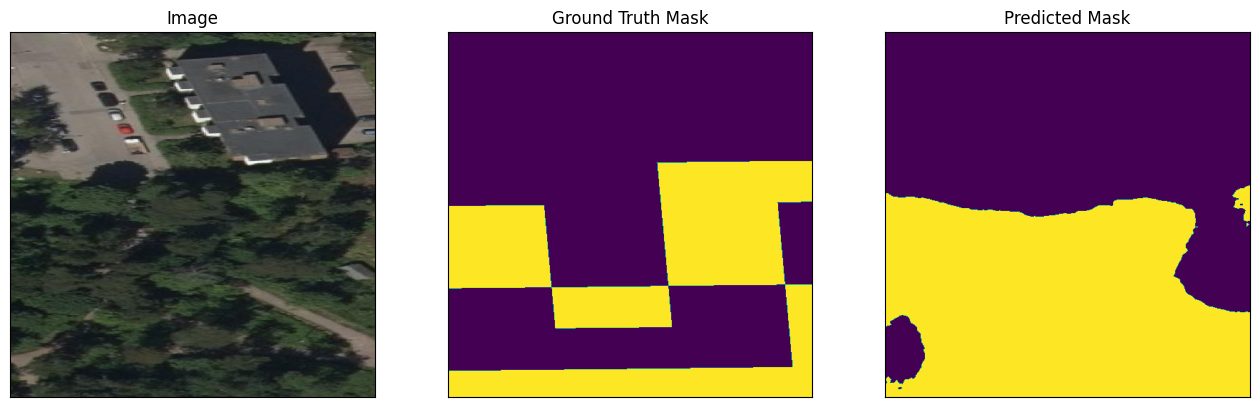

0.13394379615783691


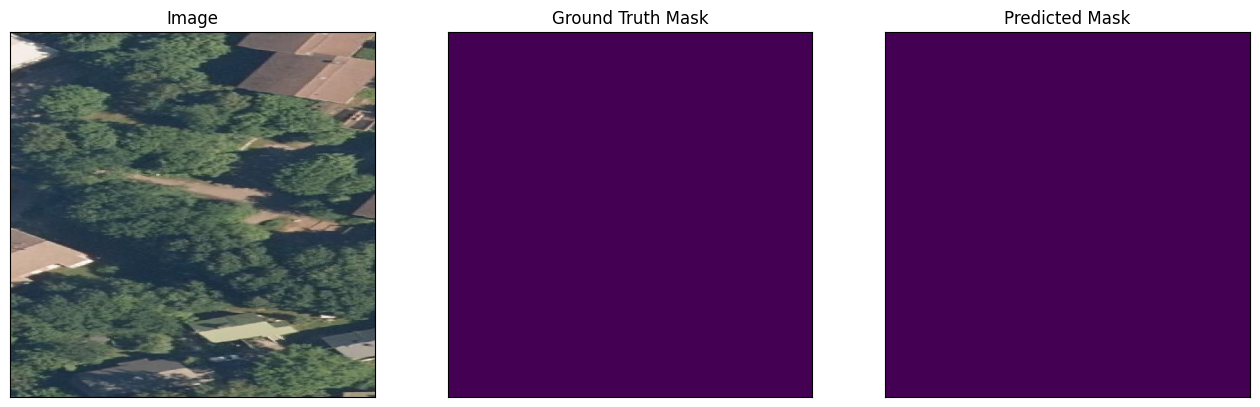

0.09089422225952148


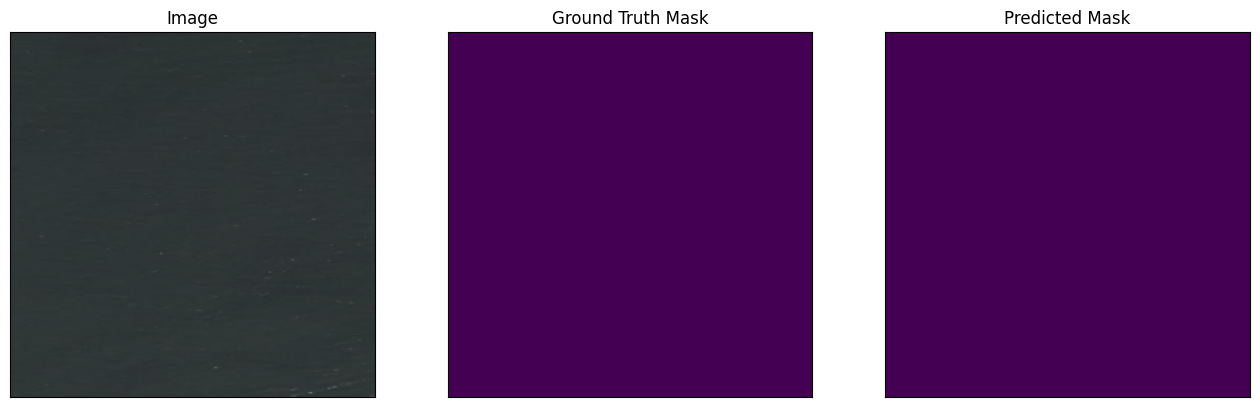

0.12519192695617676


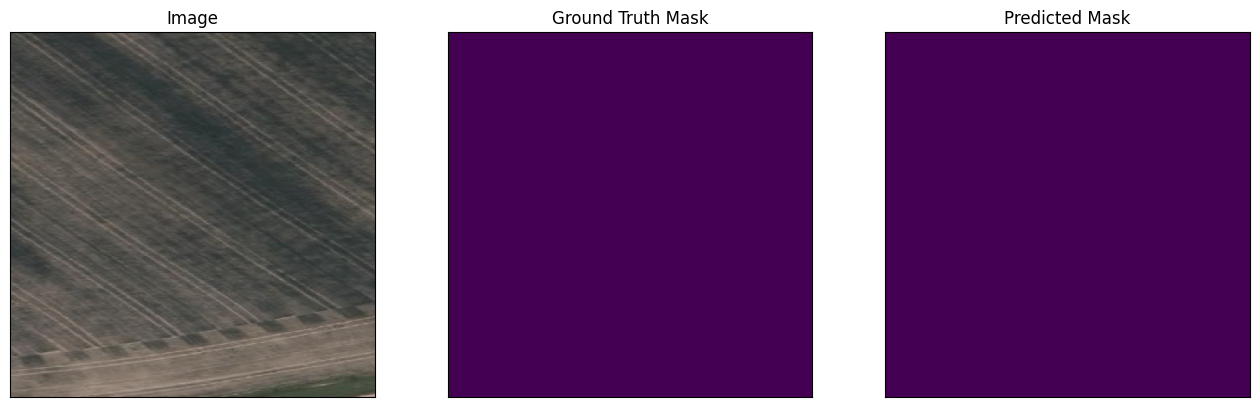

0.10625290870666504


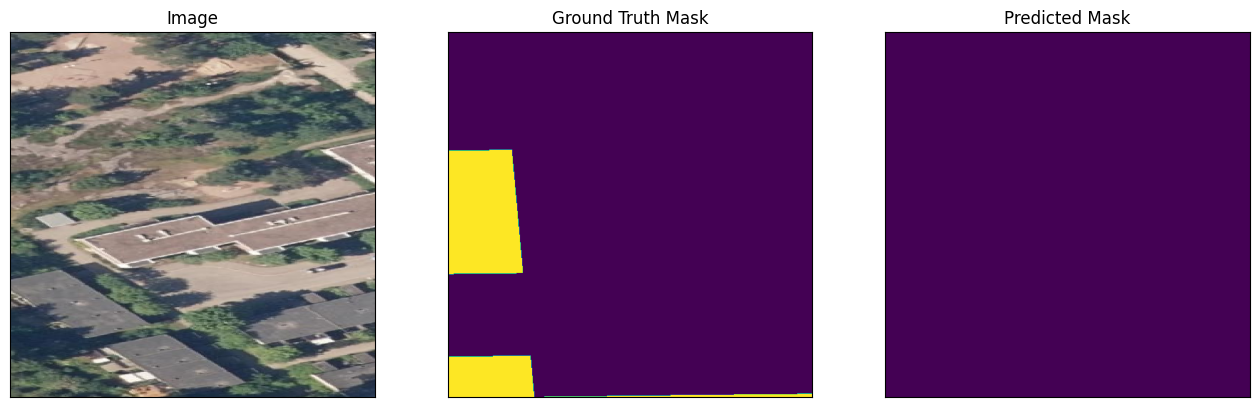

0.12191915512084961


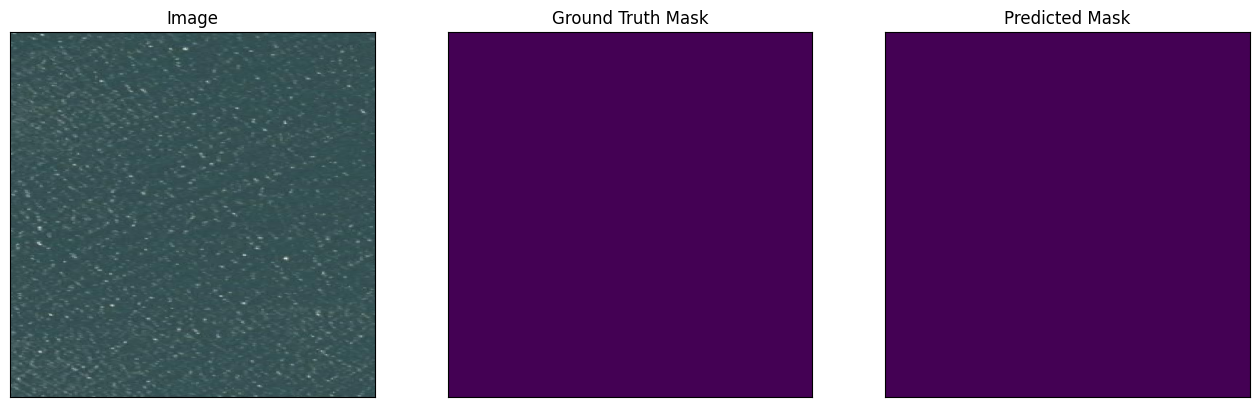

0.17224907875061035


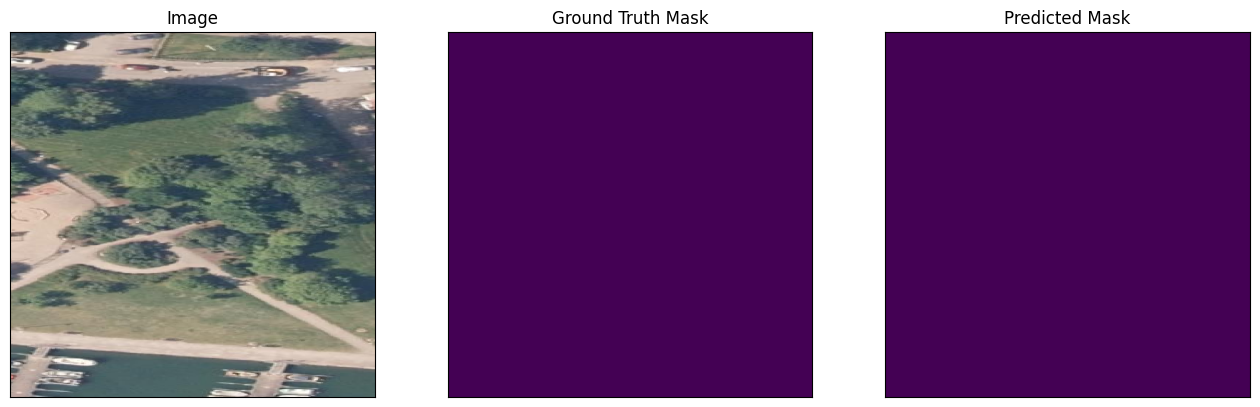

0.10206103324890137


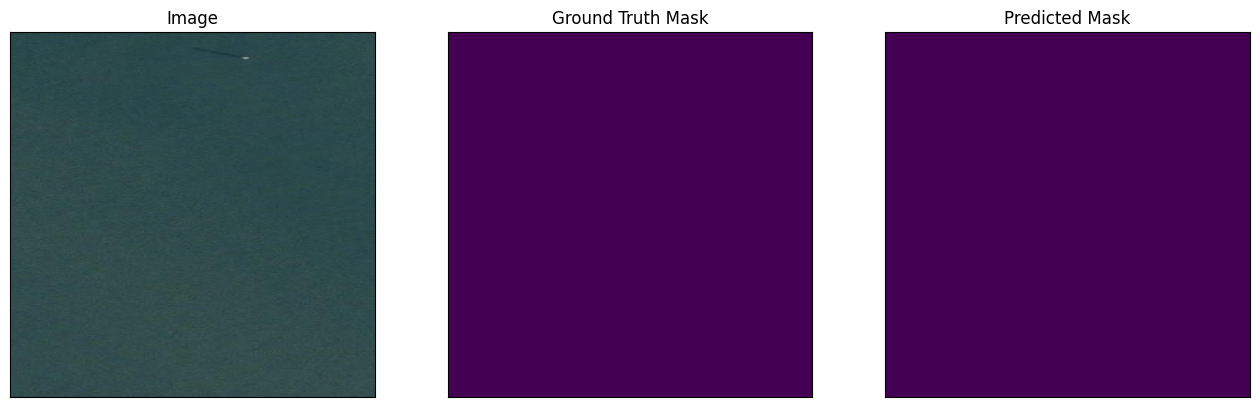

0.08566999435424805


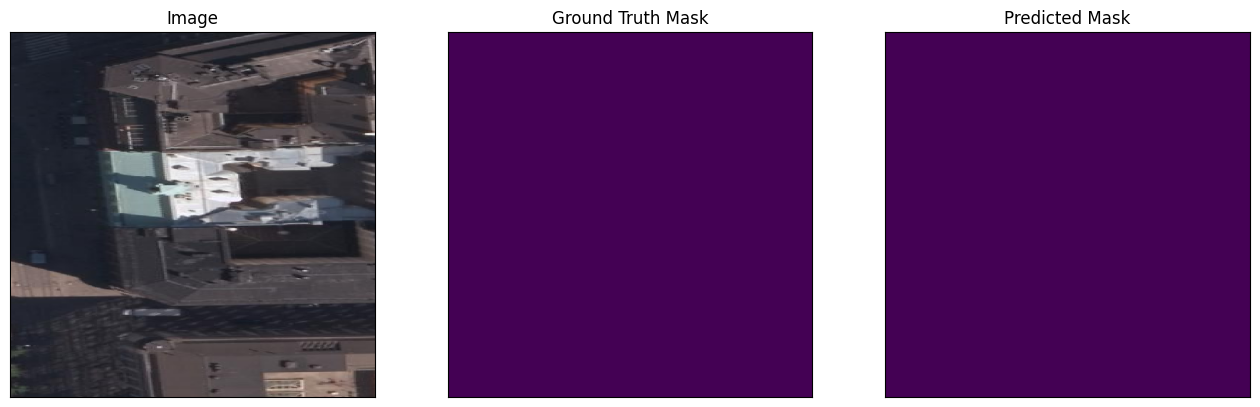

0.09551715850830078


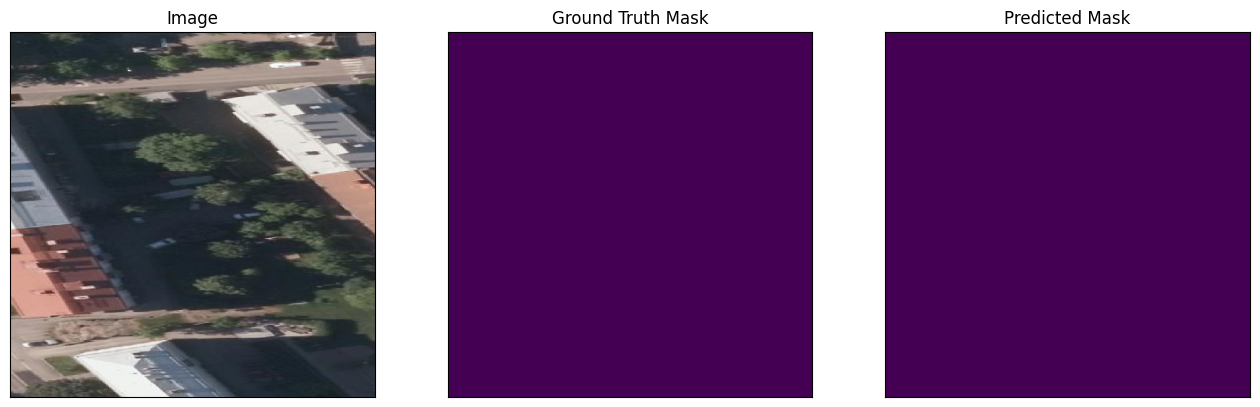

0.11607885360717773


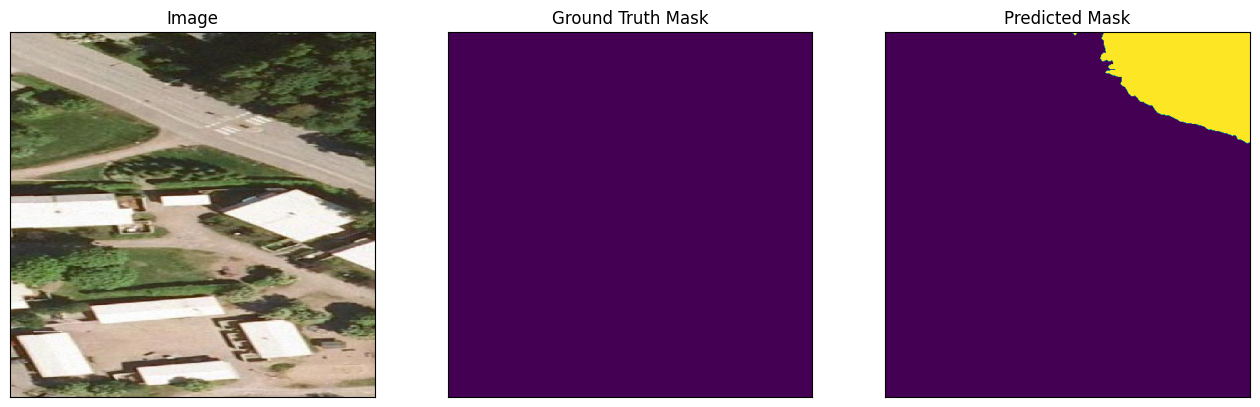

0.11515522003173828


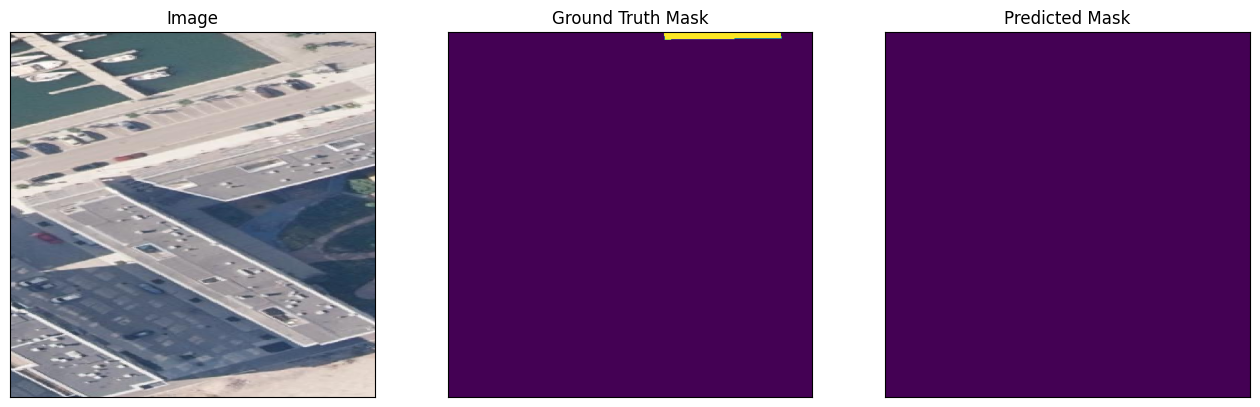

0.18097972869873047


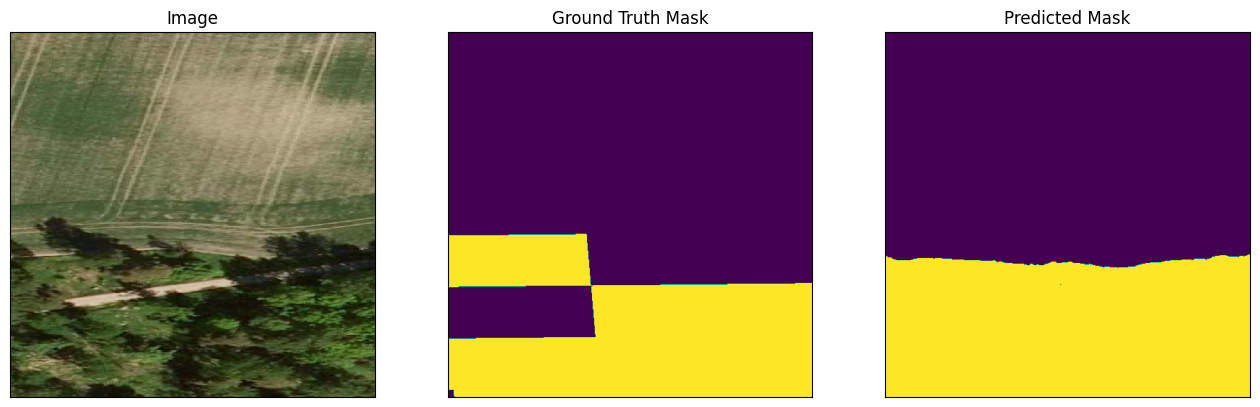

0.11969995498657227


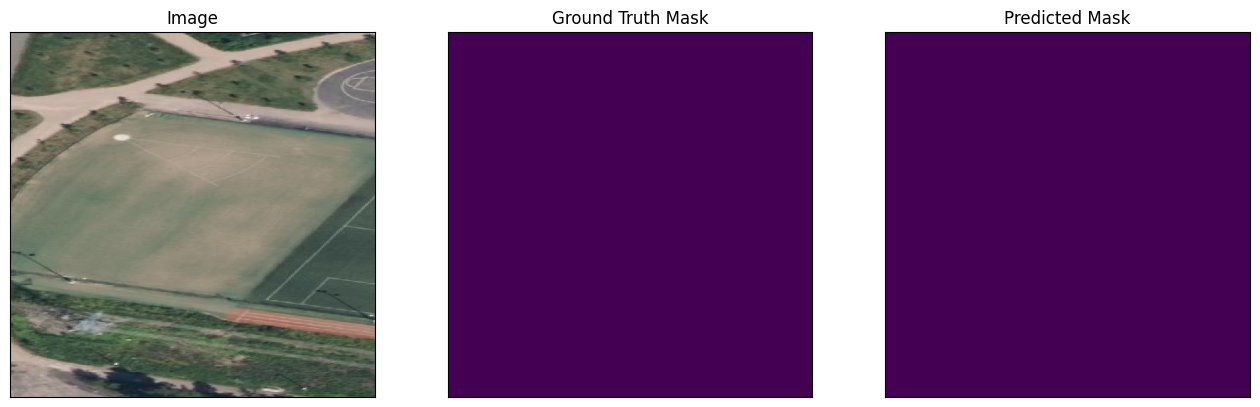

0.10326361656188965


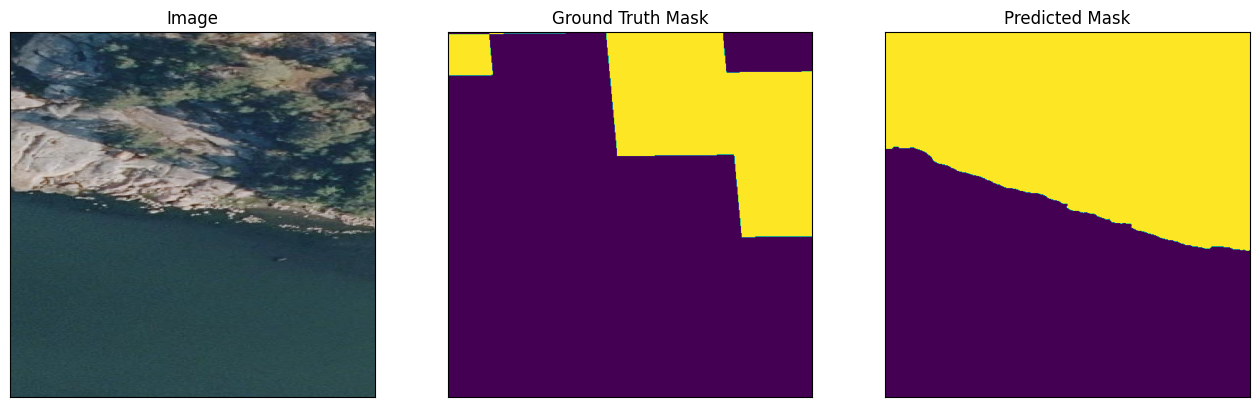

0.10688209533691406


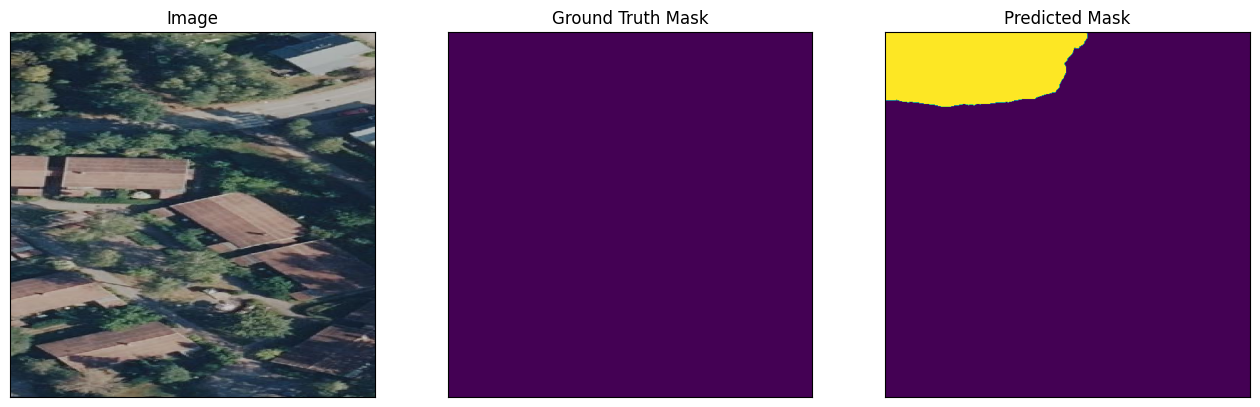

0.09982991218566895


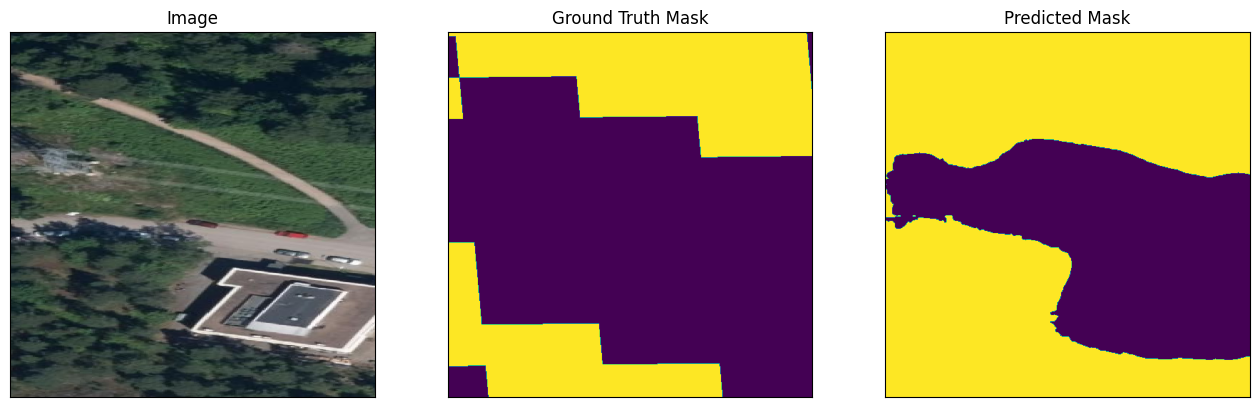

0.27532362937927246


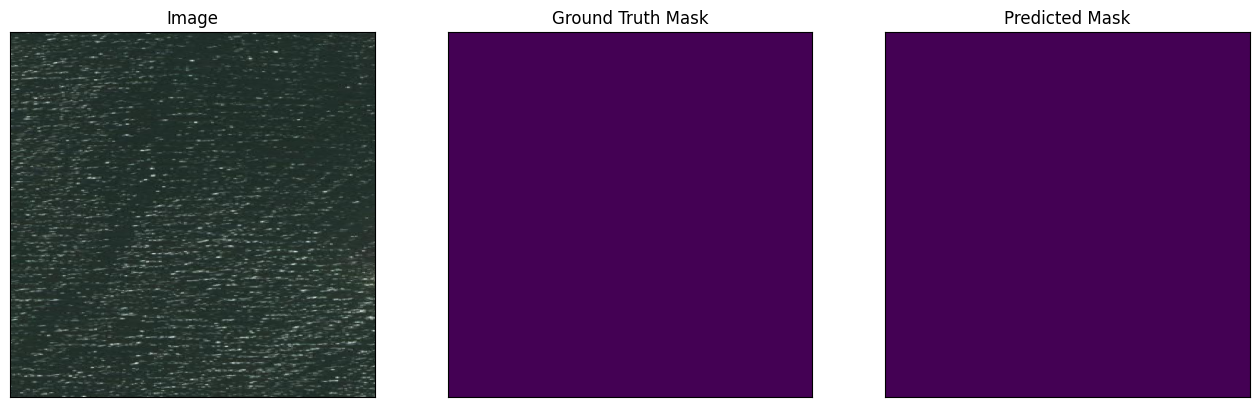

0.13424015045166016


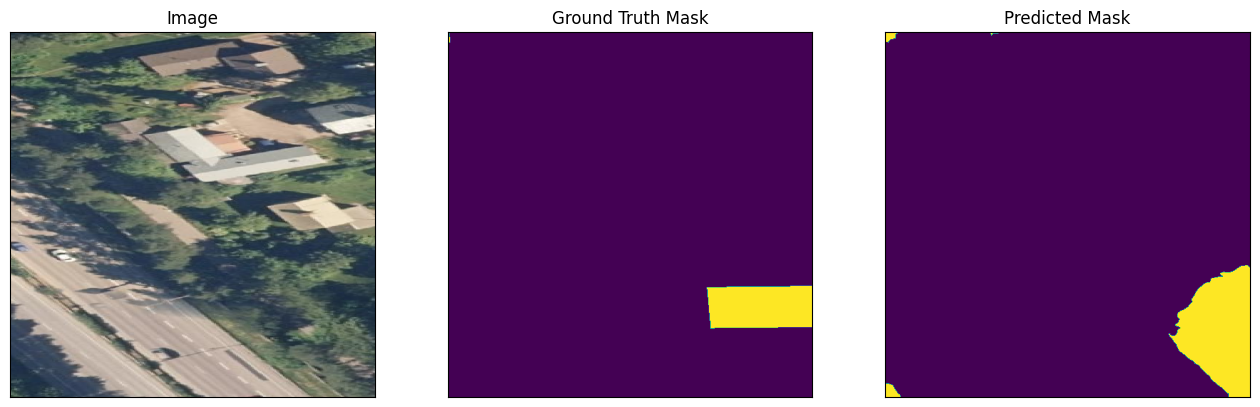

0.09285259246826172


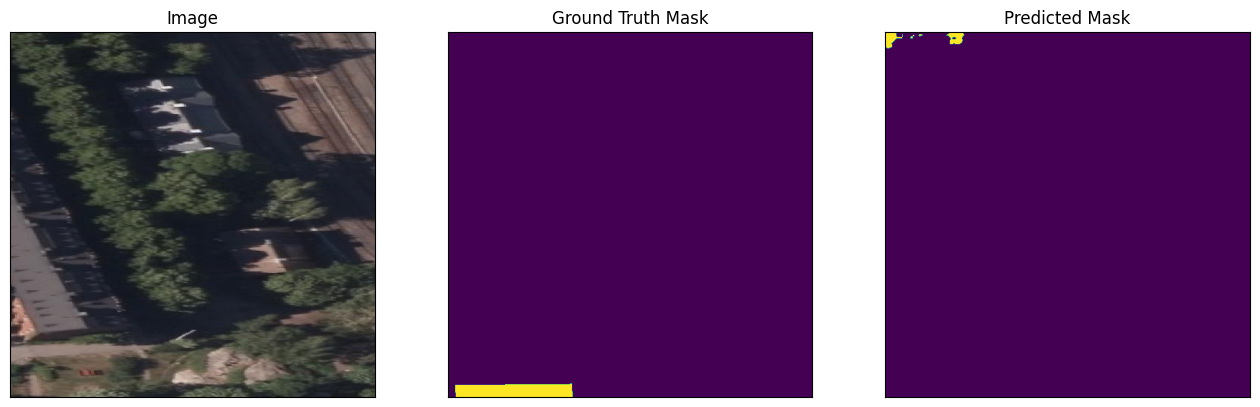

In [ ]:
# import time

# for i in range(20):
#     n = np.random.choice(len(test_dataset))

#     t1 = time.time()
    
#     image_vis = test_dataset_vis[n][0].astype('uint8')
#     image, gt_mask = test_dataset[n]

#     gt_mask = gt_mask.squeeze()

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = model.predict(x_tensor)
#     pr_mask = (pr_mask.squeeze().cpu().numpy().round())

#     print(time.time()-t1)
    
#     visualize(image=image_vis,
#               ground_truth_mask=gt_mask,
#               predicted_mask=pr_mask)
